In [50]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions as et
%matplotlib inline

### Make some helper functions

In [122]:
def MakeLabel(Treat):
    label = ''
    for level in Treat.index:
        label += str(Treat.loc[level]) + ' '
    return label

def MakeYearIndex(Year):
    GraphTreats = GrandIndex.loc[Year,:].dropna(axis=1,how='all')
    for Fact in GraphTreats.columns:
        if len(GraphTreats.loc[:,Fact].drop_duplicates()) <=1:
            GraphTreats.drop(Fact,axis=1,inplace=True)
    return GraphTreats

def SetLineSymbols(Index):
    Colors = ['red','orange','blue','green','black','pink']
    Markers = ['o-','s-','^-','*-','+-','x-']
    Sizes = [12,10,8,6,4,2]
    Demarkers = [Colors, Markers, Sizes]
    DemarkerIndex = []
    FactorNumber = 0
    for Fact in Index.columns:
        LevelList = Index.loc[:,Fact].drop_duplicates().values
        FactorLevels = LevelList.size
        LevelDemarkers = Demarkers[FactorNumber][0:FactorLevels]
        LevelPairs = pd.Series(data=LevelDemarkers, index=LevelList)
        DemarkerIndex.append(LevelPairs)
        FactorNumber +=1
    return DemarkerIndex

def SetSymbols(Index):
    Colors = ['red','orange','blue','green']
    Markers = ['o','s','^','*','+','x']
    Sizes = [12,10,8,6,4,2]
    Demarkers = [Colors, Markers, Sizes]
    DemarkerIndex = []
    FactorNumber = 0
    for Fact in Index.columns:
        LevelList = Index.loc[:,Fact].drop_duplicates().values
        FactorLevels = LevelList.size
        LevelDemarkers = Demarkers[FactorNumber][0:FactorLevels]
        LevelPairs = pd.Series(data=LevelDemarkers, index=LevelList)
        DemarkerIndex.append(LevelPairs)
        FactorNumber +=1
    return DemarkerIndex

def FindAxisMax(DataArray):
    Max = np.percentile(pd.to_numeric(DataArray.dropna()),99)
    Exponent = np.power(10,len(str(int(Max))))
    return np.ceil(Max/Exponent*10)*Exponent/10

def FindAxisMin(DataArray):
    Min = np.percentile(pd.to_numeric(DataArray.dropna()),1)
    Exponent = np.power(10,len(str(int(Min))))
    return np.floor(Min/Exponent*10)*Exponent/10

def MakeSingleVariableRegression(XVar,YVar):
    Graph = plt.figure(figsize=(10,10))
    Yup = FindAxisMax(IndexedData.loc[:,YVar ])
    Ylow = FindAxisMin(IndexedData.loc[:,YVar ])
    Xup = FindAxisMax(IndexedData.loc[:,XVar ])
    Xlow = FindAxisMin(IndexedData.loc[:,XVar ])

    pos=1
    for Year in YearList:
        Ax = Graph.add_subplot(3,2,pos)
        Ax.spines['right'].set_visible(False)
        Ax.spines['top'].set_visible(False)
        plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True)
        plt.tick_params(axis='y', which='both', left=True,right=False, labelbottom=True)
        GraphData = IndexedData.loc[IndexedData.YearSown==Year]
        GraphTreats = GrandIndex.loc[Year,:].dropna(axis=1,how='all')
        for var in GraphTreats.columns:
            LevelList = GraphTreats.loc[:,var].drop_duplicates().values
            if LevelList.size <= 1:
                GraphTreats.drop(var,axis=1,inplace=True)
        Demarkers = SetSymbols(GraphTreats)
        for Treat in GraphTreats.index:
            Filter = GraphData.TrtNum == Treat
            XData = GraphData.loc[Filter,XVar]
            YData = GraphData.loc[Filter,YVar]
            col = Demarkers[0][GraphTreats.loc[Treat][0]]
            mark = Demarkers[1][GraphTreats.loc[Treat][1]]
            plt.plot(XData,YData,mark,color=col,markersize=12)
            plt.plot([Xlow,Xup],[Ylow,Yup],'--',color='k')
            plt.title(Year,fontsize = 20)
        plt.ylim(Ylow,Yup)
        plt.xlim(Xlow,Xup)
        Ax.set_xticks([Ax.get_xticks()[0],Ax.get_xticks()[-1]])
        Ax.set_yticks([Ax.get_yticks()[1],Ax.get_yticks()[-1]])
        if pos in [1,3]:
            plt.ylabel(YVar,fontsize=16)
        if pos in [2,3]:
            plt.xlabel(XVar,fontsize=16)
        pos+=1

def MakeHarvestVariableGraph(Variable):
    Graph = plt.figure(figsize=(10,10))
    pos=1
    TreatInLabel = pd.Series(index = YearList, data = [[1],[1],[0,2],[0,2],[0,2]])
    Yup = FindAxisMax(IndexedData.loc[:,Variable ])
    for Year in YearList:
        Pannel = Graph.add_subplot(len(YearList),1,pos)
        plt.ylim(0,Yup)
        plt.tick_params(labelsize=20)
        Pannel.tick_params(labelbottom=False)
        if Year == 2014:
            plt.ylabel(Variable, fontsize = 20)
        GraphData = pd.to_numeric(IndexedData[GS90Filter].loc[Year,Variable].dropna())
        MeanData = GraphData.groupby(GraphData.index.names).mean()
        Left = 0
        count = 0
        LastSowIndex = MeanData.index[count][0]
        for Treat in MeanData.index:
            SowLab = pd.to_datetime(MeanData.index[count][0]).strftime('%d-%b')
            if count == 0:
                plt.text(Left+1,Yup*0.9,SowLab,fontsize=18)
            if LastSowIndex != MeanData.index[count][0]:
                Left+=1
                plt.text(Left+1,Yup*0.9,SowLab,fontsize=18)
            plt.bar(x=Left+.5,height=MeanData[count],color='lightgrey')
            FullLab = MeanData.index[count][1:]
            forShort = TreatInLabel[Year]
            LabMembers = [FullLab[i] for i in forShort]
            Label = ''
            for member in LabMembers:
                Label += str(member)
                Label += '  '
            height = MeanData[count] * 0.95
            plt.text(Left+.7,height, Label,rotation=90, fontsize=10)
            Left += 1
            LastSowIndex = MeanData.index[count][0]
            count += 1
        pos +=1
        
def MakeTimeCoarseGraph(Year,Variable):
    GraphData = Data.loc[Data.YearSown==Year]
    GraphTreats = GrandIndex.loc[Year,:].dropna(axis=1,how='all')
    for var in GraphTreats.columns:
            LevelList = GraphTreats.loc[:,var].drop_duplicates().values
            if LevelList.size <= 1:
                GraphTreats.drop(var,axis=1,inplace=True)
    Demarkers = SetLineSymbols(GraphTreats)
    Graph = plt.figure(figsize=(8,6))

    for Treat in GraphTreats.index:
        Filter = (Data.YearSown == Year) & (Data.TrtNum == Treat)
        GraphData = Data.loc[Filter,Variable].dropna().groupby(level='SampleDate').mean()
        col = Demarkers[0][GraphTreats.loc[Treat][0]]
        mark = Demarkers[1][GraphTreats.loc[Treat][1]]
        try:
            size = Demarkers[2][GraphTreats.loc[Treat][2]]
        except:
            size = 8
        plt.plot(GraphData,mark,color = col, markersize = size,label = MakeLabel(GraphTreats.loc[Treat,:]))
    plt.xticks(rotation=45)
    plt.ylabel(Variable,fontsize=12)
    plt.tick_params(labelsize=16)
    plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
    
def MakeThermalTimeCoarseGraphWithGS(Variable,GSsToGraph,YearsToGraph):
    Colors = ['red','orange','blue','green']
    Markers = ['o-','s-','^-','*-']
    Markers2 = ['o','s','^','*']
    Sizes = [12,10,8,6,4,2]
    Graph = plt.figure(figsize=(12,16))
    YearPos = 0
    for Year in YearsToGraph:
        filter = Data.loc[:,'YearSown'] == Year
        SowDates = pd.to_datetime(Data.loc[filter,'SowingDate'].drop_duplicates().values)
        TreatPos = 0
        Graph.add_subplot(3,1,YearPos+1)
        for Treat in SowDates:
            Filter = (Data.YearSown == Year) & (Data.SowingDate == Treat) & (Data.Cultivar == 'Wakanui')  & (Data.PlantPopn==200)
            GraphData = pd.to_numeric(Data.loc[Filter,Variable].dropna()).groupby(level='SampleDate').mean()
            TtFromSow = pd.to_numeric(Data.loc[Filter,'TtFromSowing'].loc[GraphData.index].dropna()).groupby(level='SampleDate').mean()
            plt.plot(TtFromSow,GraphData,Markers[YearPos],color = Colors[TreatPos], markersize = 8)
            subfilter = (Data.loc[:,'YearSown'] == Year) & (Data.loc[:,'SowingDate']==Treat)
            Date =  Data.loc[subfilter,'GS65'].dropna().drop_duplicates()
            if len(GSsToGraph)>0:
                TtatSow = Data.loc[subfilter,'TTAtSow'].drop_duplicates()
                TTSowTo65 = MetData.loc[Date,'Tt'].values[0]-TtatSow.values[0]
                TTSowTo32 = TTSowTo65 - Post32ZadocModel.loc[Post32ZadocModel.Zstage==65,'TTsinceGS32'].values[0]
                TTSowTo45 = TTSowTo65 - Post32ZadocModel.loc[Post32ZadocModel.Zstage==45,'TTsinceGS32'].values[0]
                plt.plot([TTSowTo32,TTSowTo32],[1.1,0.0],Markers[YearPos],color = Colors[TreatPos], markersize = 8)
            TreatPos +=1
        YearPos+=1
    plt.xticks(rotation=45)
    plt.ylabel(Variable,fontsize=12)
    plt.tick_params(labelsize=16)
    plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
    
def MakeThermalTimeCoarseGraph(Variable,YearsToGraph):
    Colors = ['red','orange','blue','green']
    Markers = ['o-','s-','^-','*-']
    Markers2 = ['o','s','^','*']
    Sizes = [12,10,8,6,4,2]
    Graph = plt.figure(figsize=(12,16))
    YearPos = 0
    for Year in YearsToGraph:
        GraphData = Data.loc[Data.YearSown==Year]
        GraphTreats = MakeYearIndex(Year)
        Demarkers = SetLineSymbols(GraphTreats)
        filter = Data.loc[:,'YearSown'] == Year
        SowDates = pd.to_datetime(Data.loc[filter,'SowingDate'].drop_duplicates().values)
        TreatPos = 0
        Graph.add_subplot(3,1,YearPos+1)
        for Treat in SowDates:
            Filter = (Data.YearSown == Year) & (Data.SowingDate == Treat) #& (Data.Cultivar == 'Wakanui')  & (Data.PlantPopn==200)
            GraphData = pd.to_numeric(Data.loc[Filter,Variable].dropna()).groupby(level='SampleDate').mean()
            TtFromSow = pd.to_numeric(Data.loc[Filter,'TtFromSowing'].loc[GraphData.index].dropna()).groupby(level='SampleDate').mean()
            plt.plot(TtFromSow,GraphData,Markers[YearPos],color = Colors[TreatPos], markersize = 8)
            subfilter = (Data.loc[:,'YearSown'] == Year) & (Data.loc[:,'SowingDate']==Treat)
            TreatPos +=1
        YearPos+=1
    plt.xticks(rotation=45)
    plt.ylabel(Variable,fontsize=12)
    plt.tick_params(labelsize=16)
    plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)

### Bring in the Crop Data

In [52]:
#Data = pd.read_excel('Data compilation updated.xlsx',sheetname='DataCompiled',skiprows=[0,1,2])
#Data.to_pickle('AllData.pkl')
Data = pd.read_pickle('K:\CPDiary\Data\FAR 20by2020\AllData.pkl')

### Set up some index objects

In [53]:
TreatmentList = Data.TrtNum.drop_duplicates().values
print('TreatmentList')
print(TreatmentList)
YearList = Data.YearSown.drop_duplicates().values
print('YearList')
print(YearList)
Factors = ['Cultivar','SowingDate','PlantPopn','PGRCanopyMgmtTrt']

MetaIndex = pd.MultiIndex.from_product([YearList, TreatmentList])
GrandIndex = pd.DataFrame(index = MetaIndex, columns = Factors)
GrandIndex.sort_index(inplace=True)

print('Null Combos')
for Year in YearList:
    for Treat in TreatmentList:
        Filter = (Data.YearSown == Year) & (Data.TrtNum == Treat)
        Indicies = Data.loc[Filter,Data.columns.isin(Factors)].drop_duplicates().values
        try:
            GrandIndex.loc[(Year,Treat)] = Indicies
        except:
            print((str(Year)+' '+str(Treat)))

GrandIndex.dropna(how='all',inplace=True)

#for Treat in GrandIndex.index:
#    GrandIndex.loc[Treat,'SowingDate'] = GrandIndex.loc[Treat,'SowingDate'].to_datetime()

TreatmentList
['2a' '2e' '1a' '1e' '3a' '3e' '2c' '1c' '3c' '1d' '1b' '2f' '2d' '2b'
 '3b' '3d' '4a' '4d' '4b' '4c']
YearList
[2013 2014 2015 2016 2017]
Null Combos
2013 4a
2013 4d
2013 4b
2013 4c
2014 2e
2014 1e
2014 3e
2014 2f
2015 2e
2015 1e
2015 3e
2015 2f
2016 2e
2016 1e
2016 3e
2016 2f
2017 2e
2017 1e
2017 3e
2017 2f
2017 4a
2017 4d
2017 4b
2017 4c


### Make a data frame of zero values on sowing date

In [54]:
ValuesToZero = ['LeafNum',
'NumLeafTips',
'NumLigules',
'PercentSenescence',
'NumGreenLeaves',
'NumSenescingLeaves',
'NumDeadLeaves',
'TotalBiomass',
'TotalLeafBiomass',
'GreenLeafBiomass',
'DeadLeafBiomass',
'LAI',
'CorrLightInterception',
'CorrLAI',
'NDVI',
'NDVIHC',
'WDVI',
'NDVISC']

ZeroData = pd.DataFrame(index = GrandIndex.index, columns = Data.columns)
for treat in ZeroData.index:
    ZeroData.loc[treat,'SampleDate'] = GrandIndex.loc[treat,'SowingDate']
    ZeroData.loc[treat,'Cultivar'] = GrandIndex.loc[treat,'Cultivar']
    ZeroData.loc[treat,'SowingDate'] = GrandIndex.loc[treat,'SowingDate']
    ZeroData.loc[treat,'PlantPopn'] = GrandIndex.loc[treat,'PlantPopn']
    ZeroData.loc[treat,'PGRCanopyMgmtTrt'] = GrandIndex.loc[treat,'PGRCanopyMgmtTrt']
    ZeroData.loc[treat,'YearSown'] = treat[0]
    ZeroData.loc[treat,'TrtNum'] = treat[1]
    for val in ValuesToZero:
        ZeroData.loc[treat,val] = 0.0
for val in ValuesToZero:
    ZeroData.loc[:,val] = pd.to_numeric(ZeroData.loc[:,val])
ZeroData.reset_index(level=[0,1],inplace=True,drop=True)

### Join the zero values with the observations and index the data

In [55]:
Data = Data.append(ZeroData,sort=False)
#Data = Data.append(ZeroData2013)
Data.set_index('SampleDate',inplace=True,drop=False)
Data.sort_values(by='SowingDate',inplace=True)

### Add Truncated Sowing date into index and sort

In [56]:
for Treat in GrandIndex.index:
    GrandIndex.loc[Treat,'SowingDate'] = GrandIndex.loc[Treat,'SowingDate'].strftime('%d-%b')

TreatmentOrder = ['SowingDate','Cultivar','PlantPopn','PGRCanopyMgmtTrt']
GrandIndex = GrandIndex[TreatmentOrder]

### Bring in the Met data and calculate a few variables

In [62]:
MetData = pd.read_csv('.\Weather\LincolnClean.met',sep='\t')
MetData.set_index('Date', inplace=True)
MetData.index = pd.to_datetime(MetData.index)
MetData.loc[:,'MeanT'] = np.divide(np.add(MetData.loc[:,'MinT'],MetData.loc[:,'MaxT']),2)
MetData.loc[:,'Tt'] = MetData.loc[:,'MeanT'].cumsum()

In [63]:
for Year in YearList:
    filter = Data.loc[:,'YearSown']==Year
    if Year == 2013:
        FirstNDVI = dt.datetime(2013,5,28)
        LastNDVI = dt.datetime(2013,10,1)
        filter2 = filter & ((Data.SampleDate < FirstNDVI) | (Data.SampleDate > LastNDVI))
        Data.loc[filter2,'I/Io'] = Data.loc[filter2,'CorrLightInterception']
        filter3 = filter & (Data.SampleDate >= FirstNDVI) & (Data.SampleDate <= LastNDVI)
        Data.loc[filter3,'I/Io'] = Data.loc[filter3,'NDVISC']
    else:
        Data.loc[filter,'I/Io'] = Data.loc[filter,'NDVISC']
Data.loc[Data.loc[:,'SampleGS']=='GS90','I/Io'] = 0

## Calculate Thermal time after sowing for each sampling date

In [65]:
for Year in YearList:
    filter = Data.loc[:,'YearSown'] == Year
    SowDates = pd.to_datetime(Data.loc[filter,'SowingDate'].drop_duplicates().values)
    for Sow in SowDates:
        subfilter = (Data.loc[:,'YearSown'] == Year) & (Data.loc[:,'SowingDate']==Sow)
        Data.loc[subfilter,'TTAtSow'] = MetData.loc[Sow,'Tt']        
Data.loc[:,'TtAtSample'] = [MetData.loc[X,'Tt'] for X in Data.index]
Data.loc[:,'TtFromSowing'] = Data.loc[:,'TtAtSample'] - Data.loc[:,'TTAtSow']

### Make a Dataframe for simple biomass model and interpolate Cover values into it

In [70]:
InterpDates

DatetimeIndex(['2013-02-20', '2013-02-21', '2013-02-22', '2013-02-23',
               '2013-02-24', '2013-02-25', '2013-02-26', '2013-02-27',
               '2013-02-28', '2013-03-01',
               ...
               '2014-01-19', '2014-01-20', '2014-01-21', '2014-01-22',
               '2014-01-23', '2014-01-24', '2014-01-25', '2014-01-26',
               '2014-01-27', '2014-01-28'],
              dtype='datetime64[ns]', name='Date', length=343, freq=None)

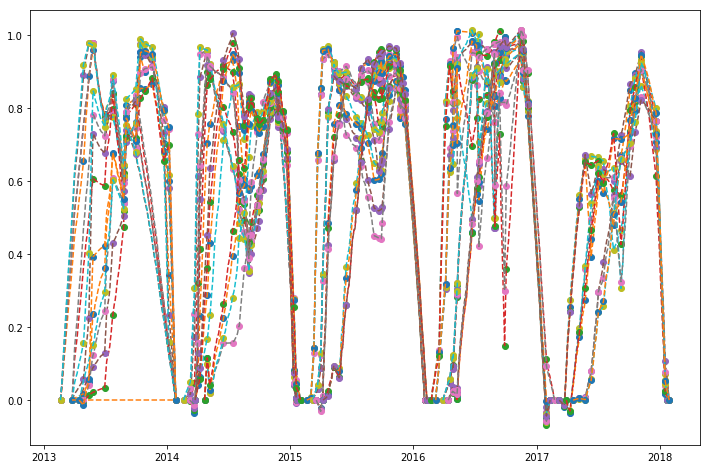

In [71]:
Graph = plt.figure(figsize=(12,8))
VarToInt = 'I/Io'#'NDVISC'
InterpolationIndex = pd.MultiIndex.from_product([YearList,TreatmentList,MetData.loc['2013-02-01':].index], names=['year', 'TrtNum', 'Date'])
BiomassAnalysis = pd.DataFrame(index = InterpolationIndex, columns=[VarToInt])
for Year in [2013,2014,2015,2016,2017]:
    YearData = Data.loc[Data.YearSown==Year,:]
    YearIndex = GrandIndex.loc[Year,:].dropna(axis=1,how='all')
    for Treat in YearIndex.index:
        Filter = YearData.TrtNum == Treat
        TreatCover = YearData.loc[Filter,VarToInt].dropna().groupby(level='SampleDate').mean()
        plt.plot(TreatCover,'o')
        Dates = TreatCover.index
        ArrayTt = MetData.loc[Dates,'Tt']
        InterpDates = MetData.loc[Dates.min():Dates.max()].index
        dailyTt = MetData.loc[InterpDates,'Tt']
        InterpCover = np.interp(dailyTt,ArrayTt,TreatCover)
        TreatIndex = pd.MultiIndex.from_product([[Year],[Treat],InterpDates],names=['Year', 'TrtNum', 'Date'])
        InterpDF = pd.DataFrame(index = TreatIndex, data=InterpCover,columns=[VarToInt])
        plt.plot(InterpDates, InterpDF.loc[:,VarToInt],'--')
        BiomassAnalysis.update(InterpDF)

### Implement simple biomass model

In [72]:
BiomassAnalysis.dropna(inplace=True)
BiomassAnalysis.sort_index(inplace=True)
for Year in [2013,2014,2015,2016,2017]:
    YearData = Data.loc[Data.YearSown==Year,:]
    YearIndex = GrandIndex.loc[Year,:].dropna(axis=1,how='all')
    for Treat in YearIndex.index:
        Rad = MetData.loc[BiomassAnalysis.loc[(Year,Treat),:].index,'Radn']
        Temp = MetData.loc[BiomassAnalysis.loc[(Year,Treat),:].index,'MeanT']
        BiomassAnalysis.loc[(Year,Treat),'Radn'] = Rad.values
        BiomassAnalysis.loc[(Year,Treat),'Temp'] = Temp.values
BiomassAnalysis.loc[:,'IntRadn'] = BiomassAnalysis.loc[:,VarToInt] * BiomassAnalysis.loc[:,'Radn']
XTemp = [-10,0,15,25,35]
YRUE = [0,0,15,15,0]
BiomassAnalysis.loc[:,'RUE'] = [np.interp(BiomassAnalysis.loc[x,'Temp'],XTemp,YRUE) for x in BiomassAnalysis.index]
BiomassAnalysis.loc[:,'PotDM'] = BiomassAnalysis.loc[:,'RUE'] * BiomassAnalysis.loc[:,'IntRadn']

TreatsWithIncompleteRadnData = [(2013,'1b'),(2013,'2b'),(2013,'3b'),
                               (2013,'1d'),(2013,'2d'),(2013,'3d'),
                                (2013,'2f'),
                               (2015,'4d')]
for Incomplete in TreatsWithIncompleteRadnData:
    BiomassAnalysis.loc[Incomplete,:] = np.nan

## Graph Zadoc stage againts TT since sowing for 2014 where we have good data

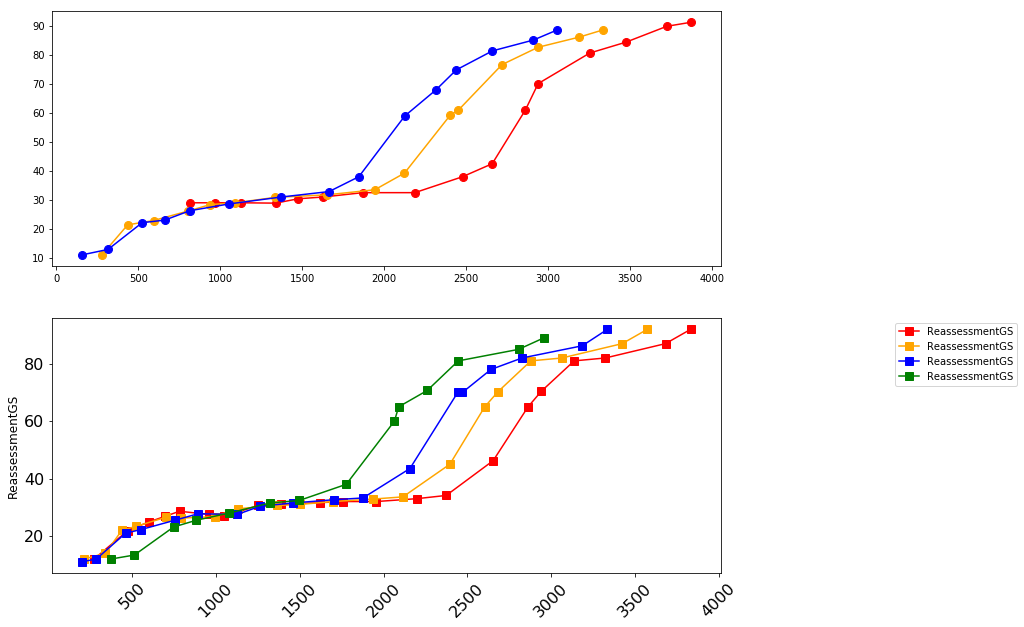

In [73]:
Variable = 'ReassessmentGS'
MakeThermalTimeCoarseGraph(Variable,[2013,2014])

## Following GS32 the sowing dates appear to have a similar pattern.  The differences in time to GS32 are related to final leaf number and these can be offset.  Lets look at leaf numbers first for 2014 where zadoc data is best

### First sow date had 17 leaves, then 15.5, 14.5, and 13 leaves for the final sow date.  All of these leaves will be appearing with a large phyllochron and this many phyllochrons can be removed to align the zadoc data post stage 32 for model fitting.

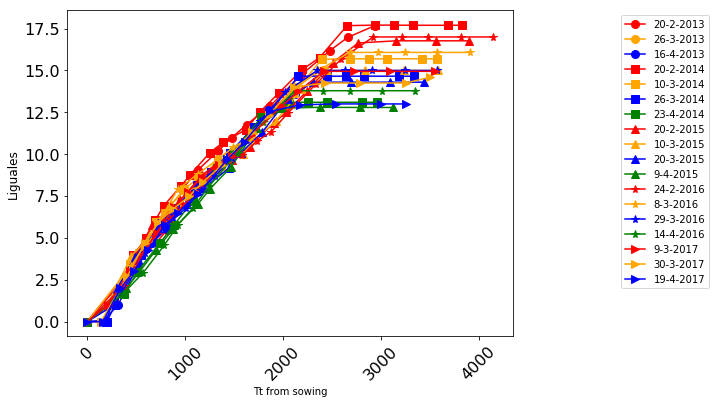

In [74]:
Colors = ['red','orange','blue','green']
Markers = ['o-','s-','^-','*-','>-']
Sizes = [12,10,8,6,4,2]
Graph = plt.figure(figsize=(8,6))
YearPos = 0
for Year in YearList:
    Filter = Data.loc[:,'YearSown'] == Year
    SowDates = pd.to_datetime(Data.loc[Filter,'SowingDate'].drop_duplicates().values)
    TreatPos = 0
    for Treat in SowDates:
        Filter = (Data.YearSown == Year) & (Data.SowingDate == Treat) & (Data.Cultivar == 'Wakanui')  & ((Data.PlantPopn==200) | (Data.PlantPopn==50) |(Data.PlantPopn==150)) & (Data.PGRCanopyMgmtTrt == 'Normal')
        GraphData = pd.to_numeric(Data.loc[Filter,'NumLigules'].dropna()).groupby(level='SampleDate').mean()
        TtFromSow = pd.to_numeric(Data.loc[Filter,'TtFromSowing'].loc[GraphData.index].dropna()).groupby(level='SampleDate').mean()
        plt.plot(TtFromSow,GraphData,Markers[YearPos],color = Colors[TreatPos], markersize = 8,label = str(Treat.day)+'-'+str(Treat.month)+'-'+str(Treat.year))
        TreatPos +=1
    YearPos+=1
plt.xticks(rotation=45)
plt.ylabel('Liguales',fontsize=12)
plt.xlabel('Tt from sowing')
plt.tick_params(labelsize=16)
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)

### Export ligule data for Pierre

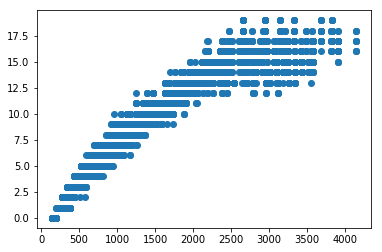

In [75]:
include = ['SowingDate','TtFromSowing','NumLigules','PlantPopn','Block']
Filter = (Data.Cultivar == 'Wakanui')  & ((Data.PlantPopn==200) | (Data.PlantPopn==50) |(Data.PlantPopn==150)) & (Data.PGRCanopyMgmtTrt == 'Normal')
LeafData = Data.loc[Filter,include].dropna()
plt.plot(LeafData.TtFromSowing,LeafData.NumLigules,'o')
LeafData.loc[:,'Year'] = [LeafData.SowingDate[x].year for x in range(LeafData.index.size)]
LeafData.to_excel('2020LiguleData.xlsx',sheet_name = 'Ligules',merge_cells=False)
MetData.to_excel('2020MetData.xlsx',sheet_name = 'MetData',merge_cells=False,)

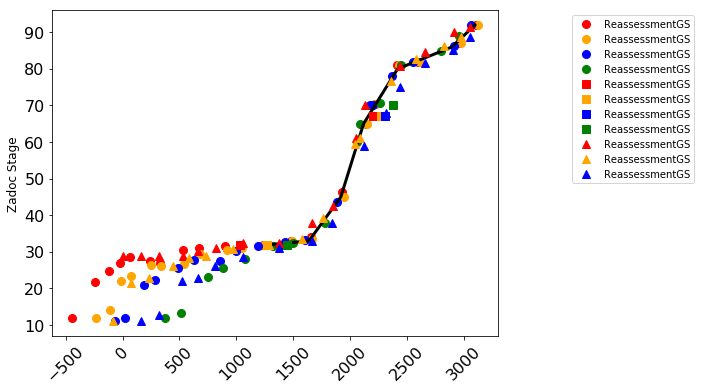

In [76]:
Colors = ['red','orange','blue','green']
phyllochron = 180
ExtraLeaves = [4,2.5,1.5,0]
Offsets = np.multiply(ExtraLeaves,phyllochron)
Graph = plt.figure(figsize=(8,6))
YearPos = 0
filter = Data.loc[:,'YearSown'] == 2014
SowDates = pd.to_datetime(Data.loc[filter,'SowingDate'].drop_duplicates().values)
TreatPos = 0
for Treat in SowDates:
    Filter = (Data.YearSown == 2014) & (Data.SowingDate == Treat) 
    GraphData = pd.to_numeric(Data.loc[Filter,'ReassessmentGS'].dropna()).groupby(level='SampleDate').mean()
    TtFromSow = pd.to_numeric(Data.loc[Filter,'TtFromSowing'].loc[GraphData.index].dropna()).groupby(level='SampleDate').mean() 
    TtFrom32 = np.subtract(TtFromSow, Offsets[TreatPos])
    plt.plot(TtFrom32,GraphData,'o',color = Colors[TreatPos], markersize = 8)
    TreatPos +=1
YearPos+=1
plt.xticks(rotation=45)
plt.ylabel('Zadoc Stage',fontsize=12)
plt.tick_params(labelsize=16)
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)

#Model to quantify development post GS32
OffsetTtSowing = [1300, 1640, 1920, 2120, 2420, 2900, 3100]
Zstage = [32, 33, 45, 65, 80, 86, 92]

plt.plot(OffsetTtSowing,Zstage,'-',color='k',Linewidth=3)

ExtraLeaves = [4,2.5,1.5,0]
Offsets = np.multiply(ExtraLeaves,phyllochron)
YearPos = 0
filter = Data.loc[:,'YearSown'] == 2015
SowDates = pd.to_datetime(Data.loc[filter,'SowingDate'].drop_duplicates().values)
TreatPos = 0
for Treat in SowDates:
    Filter = (Data.YearSown == 2015) & (Data.SowingDate == Treat) 
    GraphData = pd.to_numeric(Data.loc[Filter,'ReassessmentGS'].dropna()).groupby(level='SampleDate').mean()
    TtFromSow = pd.to_numeric(Data.loc[Filter,'TtFromSowing'].loc[GraphData.index].dropna()).groupby(level='SampleDate').mean() 
    TtFrom32 = np.subtract(TtFromSow, Offsets[TreatPos])
    plt.plot(TtFrom32,GraphData,'s',color = Colors[TreatPos], markersize = 8)
    TreatPos +=1
YearPos+=1
plt.xticks(rotation=45)
plt.tick_params(labelsize=16)
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)

ExtraLeaves = [4.5,2,0]
Offsets = np.multiply(ExtraLeaves,phyllochron)
YearPos = 0
filter = Data.loc[:,'YearSown'] == 2013
SowDates = pd.to_datetime(Data.loc[filter,'SowingDate'].drop_duplicates().values)
TreatPos = 0
for Treat in SowDates:
    Filter = (Data.YearSown == 2013) & (Data.SowingDate == Treat) 
    GraphData = pd.to_numeric(Data.loc[Filter,'ReassessmentGS'].dropna()).groupby(level='SampleDate').mean()
    TtFromSow = pd.to_numeric(Data.loc[Filter,'TtFromSowing'].loc[GraphData.index].dropna()).groupby(level='SampleDate').mean() 
    TtFrom32 = np.subtract(TtFromSow, Offsets[TreatPos])
    plt.plot(TtFrom32,GraphData,'^',color = Colors[TreatPos], markersize = 8)
    TreatPos +=1
YearPos+=1
plt.xticks(rotation=45)
plt.tick_params(labelsize=16)
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)

### Now we have a model to interpolate zadox stage from a given date, package it into a data frame

In [77]:
Post32ZadocModel = pd.DataFrame(columns = ['TTsinceGS32','Zstage'])
Post32ZadocModel.TTsinceGS32 = np.subtract(OffsetTtSowing,OffsetTtSowing[0])
Post32ZadocModel.Zstage = Zstage

# Make a dataframe with indexing needed for doing harvest summary and determine crop specific variables

In [78]:
Index = ['YearSown','SowingDate','Cultivar','PlantPopn','PGRCanopyMgmtTrt','Block']
IndexedData = Data.set_index(Index,drop=False)
IndexedData.sort_index(inplace=True)
#Make filters for selecting specific sample timings
GS32Filter = (IndexedData.loc[:,'SampleGS']=='GS32').values
GS65Filter = (IndexedData.loc[:,'SampleGS']=='GS65').values
GS90Filter = (IndexedData.loc[:,'SampleGS']=='GS90').values
#Calculate Anthesis parameters
IndexedData.loc[GS90Filter,'AnthesisStem'] = IndexedData.loc[GS65Filter,'StemBiomass']
IndexedData.loc[GS90Filter, 'VegetativeBiomass'] = IndexedData.loc[GS32Filter,'TotalBiomass']                                     
IndexedData.loc[GS90Filter, 'AnthesisBiomass'] = IndexedData.loc[GS65Filter,'TotalBiomass']                                     
IndexedData.loc[GS90Filter,'GrainsPerGramStem'] = IndexedData.loc[GS90Filter,'GrainsMSq']/(IndexedData.loc[GS65Filter,'StemBiomass']/10)
IndexedData.loc[GS90Filter,'1000GrainWt0Pc'] = IndexedData.loc[GS90Filter,'ThousandGrainWeight'] * (100-IndexedData.loc[GS90Filter,'GrainMoisture'])/100
IndexedData.loc[GS90Filter, 'GS32to65Biomass'] = IndexedData.loc[GS90Filter, 'AnthesisBiomass'] - IndexedData.loc[GS90Filter, 'VegetativeBiomass']
IndexedData.index = IndexedData.index.droplevel(5)

## Determine exact dates for GS32, 65 and 90 from the Zadoc Tt model defined above

In [79]:
TTat65 = np.interp(65,Post32ZadocModel.Zstage,Post32ZadocModel.TTsinceGS32)
TTat90 = np.interp(90,Post32ZadocModel.Zstage,Post32ZadocModel.TTsinceGS32)
TT65to90 = TTat90 - TTat65
for plot in IndexedData.loc[GS65Filter].index:
    GSAtSample = IndexedData.loc[GS65Filter].loc[plot].ReassessmentGS.mean()
    TTatObsDate = np.interp(GSAtSample,Post32ZadocModel.Zstage,Post32ZadocModel.TTsinceGS32)
    TTAdjust = TTat65 - TTatObsDate
    TTSowTo65 = TTAdjust + IndexedData.loc[GS65Filter].loc[plot].TtFromSowing.mean()
    TTSowTo90 = TTSowTo65 + TT65to90
    TTSowTo32 = TTSowTo65 - TTat65
    AccumTTatSow = IndexedData.loc[GS65Filter].loc[plot].TTAtSow.mean()
    AccumTTat32 = AccumTTatSow + TTSowTo32
    AccumTTat65 = AccumTTatSow + TTSowTo65
    AccumTTat90 = AccumTTatSow + TTSowTo90
    Filter = MetData.Tt == min(MetData.Tt, key=lambda x:abs(x-AccumTTat32))
    IndexedData.loc[plot,'GS32'] = MetData.loc[Filter].index[0]
    Filter = MetData.Tt == min(MetData.Tt, key=lambda x:abs(x-AccumTTat65))
    IndexedData.loc[plot,'GS65'] = MetData.loc[Filter].index[0]
    Filter = MetData.Tt == min(MetData.Tt, key=lambda x:abs(x-AccumTTat90))
    IndexedData.loc[plot,'GS90'] = MetData.loc[Filter].index[0]

### Calculate stage specific met variables

In [81]:
for Year in YearList:
    for Treat in TreatmentList:
        try:
            StartWinter = dt.datetime(Year,5,1)
            filter = (IndexedData.TrtNum == Treat) & (IndexedData.YearSown == Year)
            SowDate = IndexedData.loc[filter,'SowingDate'].dropna().drop_duplicates()[0]
            GS32Date = IndexedData.loc[filter,'GS32'].dropna().drop_duplicates()[0]
            GS65Date = IndexedData.loc[filter,'GS65'].dropna().drop_duplicates()[0]
            GS90Date = IndexedData.loc[filter,'GS90'].dropna().drop_duplicates()[0]
            RadInt = BiomassAnalysis.loc[(Year,Treat)].loc[SowDate:GS32Date].IntRadn.sum()
            Temp = BiomassAnalysis.loc[(Year,Treat)].loc[SowDate:GS32Date].Temp.mean()
            TempSum = BiomassAnalysis.loc[(Year,Treat)].loc[SowDate:GS32Date].Temp.sum()
            IndexedData.loc[filter,'VegRadn'] = RadInt
            IndexedData.loc[filter,'VegTemp'] = Temp
            IndexedData.loc[filter,'VegPTQ'] = RadInt/TempSum
            RadInt = BiomassAnalysis.loc[(Year,Treat)].loc[GS32Date:GS65Date].IntRadn.sum()
            Temp = BiomassAnalysis.loc[(Year,Treat)].loc[GS32Date:GS65Date].Temp.mean()
            TempSum = BiomassAnalysis.loc[(Year,Treat)].loc[GS32Date:GS65Date].Temp.sum()
            IndexedData.loc[filter,'GrainDevRadn'] = RadInt
            IndexedData.loc[filter,'GrainDevTemp'] = Temp
            IndexedData.loc[filter,'GrainDevPTQ'] = RadInt/TempSum
            RadInt = BiomassAnalysis.loc[(Year,Treat)].loc[GS65Date:GS90Date].IntRadn.sum()
            Temp = BiomassAnalysis.loc[(Year,Treat)].loc[GS65Date:GS90Date].Temp.mean()
            TempSum = BiomassAnalysis.loc[(Year,Treat)].loc[GS65Date:GS90Date].Temp.sum()
            IndexedData.loc[filter,'GrainFillRadn'] = RadInt
            IndexedData.loc[filter,'GrainFillTemp'] = Temp
            IndexedData.loc[filter,'GrainFillPTQ'] = RadInt/TempSum
            RadInt = BiomassAnalysis.loc[(Year,Treat)].loc[StartWinter:GS32Date].IntRadn.sum()
            Radn = MetData.Radn.loc[StartWinter:GS32Date].sum()
            Temp = MetData.MeanT.loc[StartWinter:GS32Date].mean()
            Rain = MetData.Rain.loc[StartWinter:GS32Date].sum()
            IndexedData.loc[filter,'WinterRadn'] = RadInt
            IndexedData.loc[filter,'WinterRadnTot'] = Radn
            IndexedData.loc[filter,'WinterTemp'] = Temp
            IndexedData.loc[filter,'WinterRain'] = Rain
        except:
            print(str(Year)+' '+str(Treat))
        

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


2013 4a
2013 4d
2013 4b
2013 4c
2014 2e
2014 1e
2014 3e
2014 2f
2015 2e
2015 1e
2015 3e


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


2015 2f
2016 2e
2016 1e
2016 3e
2016 2f
2017 2e
2017 1e
2017 3e
2017 2f
2017 4a
2017 4d
2017 4b
2017 4c


In [82]:
Describors = ['Block','Cultivar','Farmer','NTrt','PGRCanopyMgmtTrt',
              'PGRTrt','Plot','TrialCode','TrialCodePlot','TrtNum',
             'YearSown','Location','PGRTiming']

In [83]:
Describors = ['YearSown','Location','TrtNum','SowingDate',
              'PlantPopn','Cultivar','PGRCanopyMgmtTrt']
Filter = (Data.PlantPopn==150)&(Data.Cultivar=='Wakanui')&(Data.PGRCanopyMgmtTrt=='Normal')
Data.loc[Filter,:].groupby(Describors).mean().loc[:,]


LeafNum  \
YearSown Location TrtNum SowingDate PlantPopn Cultivar PGRCanopyMgmtTrt            
2013     Leeston  1c     2013-02-20 150       Wakanui  Normal                NaN   
                  2c     2013-03-26 150       Wakanui  Normal                NaN   
                  3c     2013-04-16 150       Wakanui  Normal                NaN   
2014     Leeston  1c     2014-02-20 150       Wakanui  Normal                NaN   
                  2c     2014-03-10 150       Wakanui  Normal                NaN   
                  3c     2014-03-26 150       Wakanui  Normal                NaN   
                  4c     2014-04-23 150       Wakanui  Normal                NaN   
2015     Wakanui  1a     2015-02-20 150       Wakanui  Normal                NaN   
                  2a     2015-03-10 150       Wakanui  Normal                NaN   
                  3a     2015-03-20 150       Wakanui  Normal                NaN   
                  4a     2015-04-09 150       Wakanui  Normal                NaN   
2016     Wakanui  1a     2016-02-24 150       Wakanui  Normal                NaN   
                  2a     2016-03-08 150       Wakanui  Normal                NaN   
                  3a     2016-03-29 150       Wakanui  Normal                NaN   
                  4a     2016-04-14 150       Wakanui  Normal                NaN   
2017     Wakanui  1a     2017-03-09 150       Wakanui  Normal                NaN   
                  2a     2017-03-30 150       Wakanui  Normal                NaN   
                  3a     2017-04-19 150       Wakanui  Normal                NaN   

                                                                         NumLeafTips  \
YearSown Location TrtNum SowingDate PlantPopn Cultivar PGRCanopyMgmtTrt                
2013     Leeston  1c     2013-02-20 150       Wakanui  Normal              12.697917   
                  2c     2013-03-26 150       Wakanui  Normal               9.368182   
                  3c     2013-04-16 150       Wakanui  Normal               7.932990   
2014     Leeston  1c     2014-02-20 150       Wakanui  Normal                    NaN   
                  2c     2014-03-10 150       Wakanui  Normal                    NaN   
                  3c     2014-03-26 150       Wakanui  Normal                    NaN   
                  4c     2014-04-23 150       Wakanui  Normal                    NaN   
2015     Wakanui  1a     2015-02-20 150       Wakanui  Normal              11.221429   
                  2a     2015-03-10 150       Wakanui  Normal               9.770909   
                  3a     2015-03-20 150       Wakanui  Normal               9.840000   
                  4a     2015-04-09 150       Wakanui  Normal               9.289916   
2016     Wakanui  1a     2016-02-24 150       Wakanui  Normal              11.710744   
                  2a     2016-03-08 150       Wakanui  Normal              12.035857   
                  3a     2016-03-29 150       Wakanui  Normal              11.064748   
                  4a     2016-04-14 150       Wakanui  Normal              10.140000   
2017     Wakanui  1a     2017-03-09 150       Wakanui  Normal              10.739865   
                  2a     2017-03-30 150       Wakanui  Normal               9.922807   
                  3a     2017-04-19 150       Wakanui  Normal               8.673004   

                                                                         NumLigules  \
YearSown Location TrtNum SowingDate PlantPopn Cultivar PGRCanopyMgmtTrt               
2013     Leeston  1c     2013-02-20 150       Wakanui  Normal             11.619792   
                  2c     2013-03-26 150       Wakanui  Normal              8.236364   
                  3c     2013-04-16 150       Wakanui  Normal              6.845361   
2014     Leeston  1c     2014-02-20 150       Wakanui  Normal                   NaN   
                  2c     2014-03-10 150       Wakanui  Normal                   NaN   
                  3c  

In [84]:
IndexedData.columns

Index(['TrialCode', 'YearSown', 'Farmer', 'Location', 'Plot', 'TrialCodePlot',
       'TrtNum', 'Block', 'Cultivar', 'SowingDate', 'PlantPopn', 'PGRTrt',
       'PGRTiming', 'PGRCanopyMgmtTrt', 'NTrt', 'SampleDate', 'ApproxGS',
       'SampleGS', 'ReassessmentGS', 'PlantNum', 'LeafNum', 'NumLeafTips',
       'NumLigules', 'ttFeb', 'ttMar', 'ttApr', 'LeafPositionNum',
       'LeafPosition', 'AvLeafSize', 'AvLeafWeight', 'AvSLA',
       'PercentSenescence', 'NumGreenLeaves', 'NumSenescingLeaves',
       'NumDeadLeaves', 'TotalBiomass', 'Grain0Percent', 'Grain14Percent',
       'StrawBiomass', 'StemBiomass', 'EarBiomass', 'ChaffBiomass',
       'TotalLeafBiomass', 'GreenLeafBiomass', 'DeadLeafBiomass',
       'GreenLeafStemRatio', 'AvStemLength', 'AvStemDW', 'StemsMSq', 'EarsMSq',
       'GrainsMSq', 'GrainsEar', 'HI', 'GrainMoisture', 'ThousandGrainWeight',
       'HectolitreGrainWeight', 'IndividGrainWt14Percent', 'LAI',
       'CorrLightInterception', 'CorrLAI', 'RED', 'NIR', 'NDVI', '

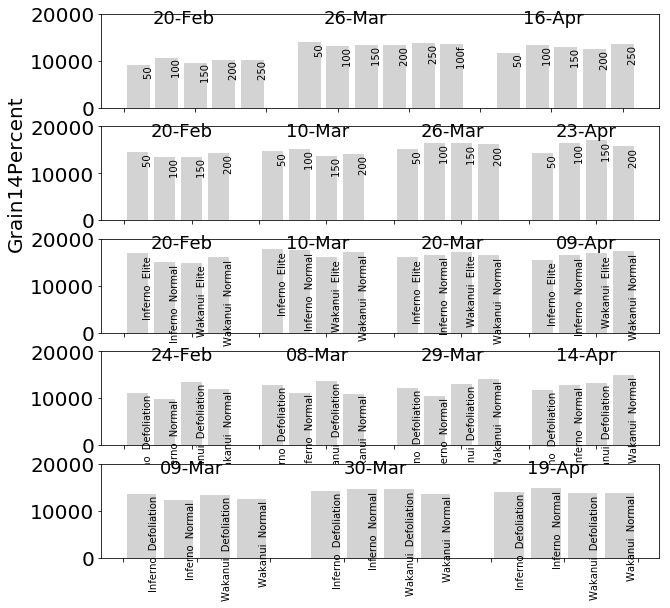

In [95]:
Variable = 'Grain14Percent'
Graph = plt.figure(figsize=(10,10))
pos=1
TreatInLabel = pd.Series(index = YearList, data = [[1],[1],[0,2],[0,2],[0,2]])
Yup = FindAxisMax(IndexedData.loc[:,Variable ])
for Year in YearList:
    Pannel = Graph.add_subplot(len(YearList),1,pos)
    plt.ylim(0,Yup)
    plt.tick_params(labelsize=20)
    Pannel.tick_params(labelbottom=False)
    if Year == 2014:
        plt.ylabel(Variable, fontsize = 20)
    GraphData = pd.to_numeric(IndexedData[GS90Filter].loc[Year,Variable].dropna())
    MeanData = GraphData.groupby(GraphData.index.names).mean()
    Left = 0
    count = 0
    LastSowIndex = MeanData.index[count][0]
    for Treat in MeanData.index:
        SowLab = pd.to_datetime(MeanData.index[count][0]).strftime('%d-%b')
        if count == 0:
            plt.text(Left+1,Yup*0.9,SowLab,fontsize=18)
        if LastSowIndex != MeanData.index[count][0]:
            Left+=1
            plt.text(Left+1,Yup*0.9,SowLab,fontsize=18)
        plt.bar(x=Left+.5,height=MeanData[count],color='lightgrey')
        FullLab = MeanData.index[count][1:]
        forShort = TreatInLabel[Year]
        LabMembers = [FullLab[i] for i in forShort]
        Label = ''
        for member in LabMembers:
            Label += str(member)
            Label += '  '
        height = MeanData[count] * 0.95
        plt.text(Left+.7,height, Label,rotation=90, fontsize=10)
        Left += 1
        LastSowIndex = MeanData.index[count][0]
        count += 1
    pos +=1

## Time series graph

(0, 1)

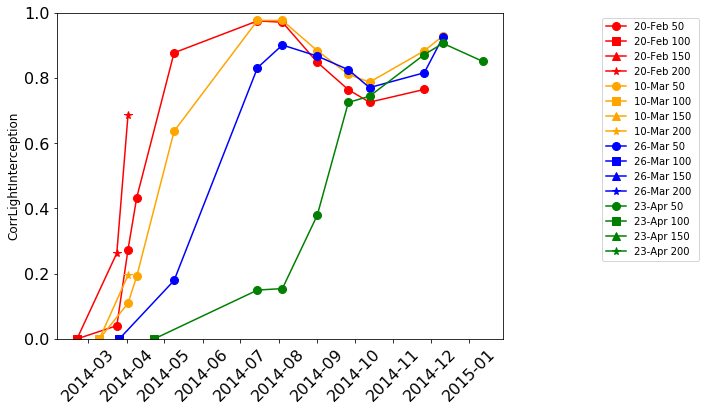

In [96]:
Year = 2014
Variable = 'CorrLightInterception'
MakeTimeCoarseGraph(Year,Variable)
plt.ylim(0,1)

(0, 1)

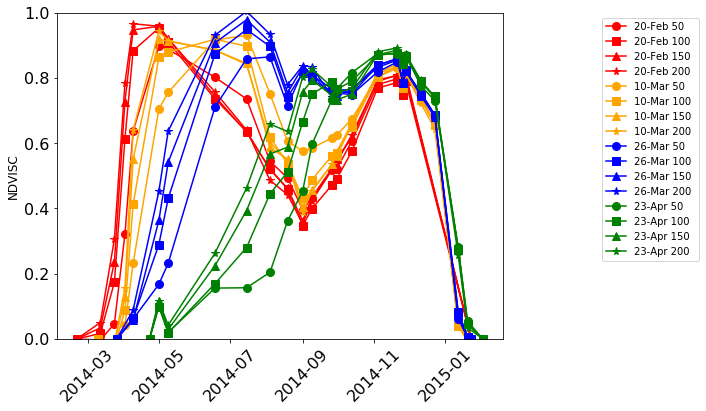

In [97]:
Year = 2014
Variable = 'NDVISC'
MakeTimeCoarseGraph(Year,Variable)
plt.ylim(0,1)

(0, 1)

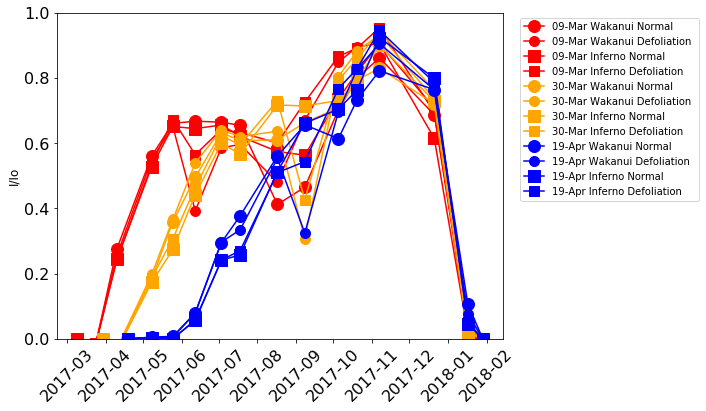

In [98]:
Year = 2017
Variable = 'I/Io'
MakeTimeCoarseGraph(Year,Variable)
plt.ylim(0,1)

## Biomass model graph

In [99]:
BiomassAnalysis.loc[2015].iloc[280:,:]

I/Io   Radn     Temp  IntRadn    RUE    PotDM
TrtNum Date                                                         
1a     2015-11-27  0.802925  16.36  18.4000  13.1359  15.00  197.038
       2015-11-28  0.802946  32.54  17.1000  26.1279  15.00  391.918
       2015-11-29  0.802961  20.82  12.5000  16.7177  12.50  208.971
       2015-11-30   0.80298  20.04  15.3500  16.0917  15.00  241.376
       2015-12-01  0.803001  22.53  17.2500  18.0916  15.00  271.374
       2015-12-02  0.796942  28.53  24.7500  22.7367  15.00  341.051
       2015-12-03  0.791923  11.03  20.5000  8.73491  15.00  131.024
       2015-12-04  0.788031  32.57  15.9000  25.6662  15.00  384.992
       2015-12-05  0.783563  20.46  18.2500  16.0317  15.00  240.476
       2015-12-06  0.780736  20.57  11.5500  16.0597  11.55   185.49
       2015-12-07  0.777737  26.15  12.2500  20.3378  12.25  249.138
       2015-12-08  0.774677  32.18  12.5000  24.9291  12.50  311.614
       2015-12-09  0.762503  26.85  14.2500  20.4732  14.25  291.743
       2015-12-10  0.745204  24.79  20.2500  18.4736  15.00  277.104
       2015-12-11  0.733927  23.14  13.2000  16.9831  13.20  224.177
       2015-12-12  0.717653  18.23  19.0500  13.0828  15.00  196.242
       2015-12-13  0.706377  15.73  13.2000  11.1113  13.20  146.669
       2015-12-14  0.693776  28.08  14.7500  19.4812  14.75  287.348
       2015-12-15  0.678954  25.51  17.3500  17.3201  15.00  259.802
       2015-12-16  0.669301  16.98  11.3000  11.3647  11.30  128.421
       2015-12-17  0.659946  23.76  10.9500  15.6803  10.95    171.7
       2015-12-18  0.649823  28.38  11.8500   18.442  11.85  218.537
       2015-12-19  0.639187  17.96  12.4500  11.4798  12.45  142.924
       2015-12-20  0.627526  19.03  13.6500  11.9418  13.65  163.006
       2015-12-21  0.612566  28.81  17.5125   17.648  15.00   264.72
       2015-12-22  0.599153   6.94  15.7000  4.15812  15.00  62.3719
       2015-12-23  0.590098  26.66  10.6000   15.732  10.60  166.759
       2015-12-24  0.577241  30.52  15.0500  17.6174  15.00  264.261
       2015-12-25  0.563487  32.55  16.1000  18.3415  15.00  275.122
       2015-12-26  0.551228  31.43  14.3500  17.3251  14.35  248.615
...                     ...    ...      ...      ...    ...      ...
4d     2016-01-13       NaN    NaN      NaN      NaN    NaN      NaN
       2016-01-14       NaN    NaN      NaN      NaN    NaN      NaN
       2016-01-15       NaN    NaN      NaN      NaN    NaN      NaN
       2016-01-16       NaN    NaN      NaN      NaN    NaN      NaN
       2016-01-17       NaN    NaN      NaN      NaN    NaN      NaN
       2016-01-18       NaN    NaN      NaN      NaN    NaN      NaN
       2016-01-19       NaN    NaN      NaN      NaN    NaN      NaN
       2016-01-20       NaN    NaN      NaN      NaN    NaN      NaN
       2016-01-21       NaN    NaN      NaN      NaN    NaN      NaN
       2016-01-22       NaN    NaN      NaN      NaN    NaN      NaN
       2016-01-23       NaN    NaN      NaN      NaN    NaN      NaN
       2016-01-24       NaN    NaN      NaN      NaN    NaN      NaN
       2016-01-25       NaN    NaN      NaN      NaN    NaN      NaN
       2016-01-26       NaN    NaN      NaN      NaN    NaN      NaN
       2016-01-27       NaN    NaN      NaN      NaN    NaN      NaN
       2016-01-28       NaN    NaN      NaN      NaN    NaN      NaN
       2016-01-29       NaN    NaN      NaN      NaN    NaN      NaN
       2016-01-30       NaN    NaN      NaN      NaN    NaN      NaN
       2016-01-31       NaN    NaN      NaN      NaN    NaN      NaN
       2016-02-01       NaN    NaN      NaN      NaN    NaN      NaN
       2016-02-02       NaN    NaN      NaN      NaN    NaN      NaN
       2016-02-03       NaN    NaN      NaN      NaN    NaN      NaN
       2016-02-04       NaN    NaN      NaN      NaN    NaN      NaN
       2016-02-05       NaN    NaN      NaN      NaN    NaN      NaN
       2016-02-06       NaN    NaN      NaN      NaN    NaN      NaN
       2016-02-07    

Text(0,0.5,'Total Biomass (t/ha)')

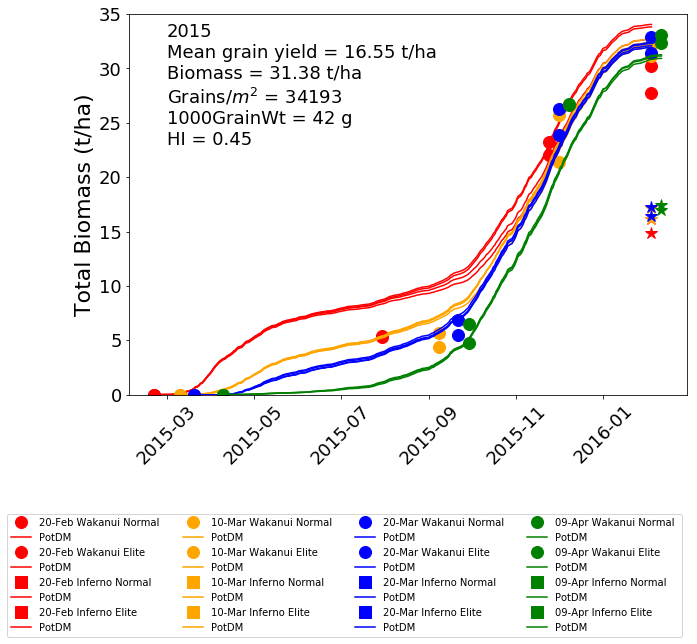

In [101]:
Year = 2015
GraphData = Data.loc[Data.YearSown==Year]
GraphTreats = MakeYearIndex(Year)
for var in GraphTreats.columns:
        LevelList = GraphTreats.loc[:,var].drop_duplicates().values
        if LevelList.size <= 1:
            GraphTreats.drop(var,axis=1,inplace=True)
Demarkers = SetSymbols(GraphTreats)
Graph = plt.figure(figsize=(10,7))

for Treat in GraphTreats.index:
    Filter = (Data.YearSown == Year) & (Data.TrtNum == Treat) & (Data.Cultivar == 'Wakanui')
    GraphData = Data.loc[Filter,'TotalBiomass'].dropna().groupby(level='SampleDate').mean()/1000
    col = Demarkers[0][GraphTreats.loc[Treat][0]]
    mark = Demarkers[1][GraphTreats.loc[Treat][1]]
    plt.plot(GraphData,mark,color = col, markersize = 12,label = MakeLabel(GraphTreats.loc[Treat,:]))
    Potbiomass = BiomassAnalysis.loc[(Year,Treat),'PotDM'].cumsum()
    plt.plot(Potbiomass/1000,'-', color=col)
    try:
        YieldData = Data.loc[Filter,'Grain14Percent'].dropna().mean()/1000
        Date =  Data.loc[Filter,'Grain14Percent'].dropna().index[0]
        plt.plot(Date,YieldData,'*',color = col, markersize = 12)
    except:
        fail = 'yes'
MeanYield = Data.loc[(Data.YearSown == Year)&(Data.Cultivar == 'Wakanui'),'Grain14Percent'].dropna().mean()/1000
MeanBiomass = Data.loc[(Data.YearSown == Year)&(Data.Cultivar == 'Wakanui')&(Data.SampleGS=='GS90'),'TotalBiomass'].dropna().mean()/1000
MeanGrainSize = IndexedData.loc[(IndexedData.YearSown == Year)&(IndexedData.Cultivar == 'Wakanui'),'1000GrainWt0Pc'].dropna().mean()
MeanGrainNumber = Data.loc[(Data.YearSown == Year)&(Data.Cultivar == 'Wakanui'),'GrainsMSq'].dropna().mean()
MeanHI = Data.loc[(Data.YearSown == Year)&(Data.Cultivar == 'Wakanui'),'HI'].dropna().mean()
PlotDate = dt.datetime(Year,3,1)
plt.text(PlotDate,23,str(Year)+'\nMean grain yield = '+'%.2f'%MeanYield + ' t/ha'+
         '\n'+ 'Biomass = ' + '%.2f'%MeanBiomass + ' t/ha' +
         '\n'+ r'Grains/$m^2$ = '+'%.0f'%MeanGrainNumber +
         '\n'+ '1000GrainWt = ' + '%.0f'%MeanGrainSize + ' g'+
         '\n'+ 'HI = '+ '%.2f'%MeanHI,fontsize=18)
plt.legend(bbox_to_anchor=(1, -0.3),numpoints=1,ncol=4)
plt.xticks(rotation=45)
plt.ylim(0,35)
plt.tick_params(labelsize=18)
plt.ylabel('Total Biomass (t/ha)',fontsize=22)

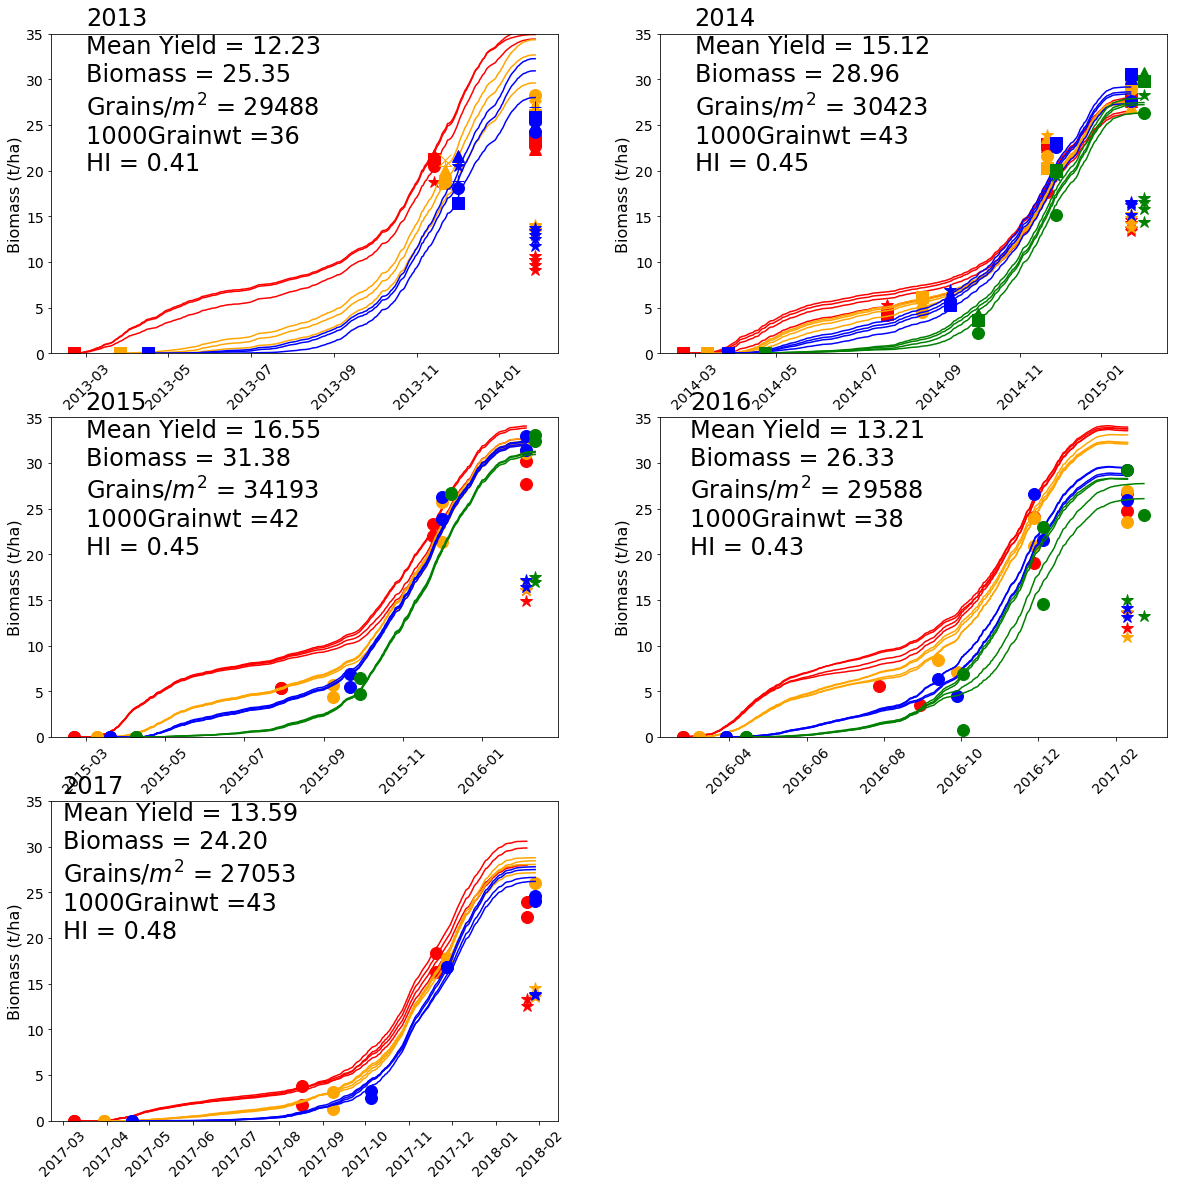

In [103]:
Graph = plt.figure(figsize=(20,20))
Pos =1
for Year in YearList:
    Graph.add_subplot(3,2,Pos)
    GraphData = Data.loc[Data.YearSown==Year]
    GraphTreats = MakeYearIndex(Year)
    for var in GraphTreats.columns:
        LevelList = GraphTreats.loc[:,var].drop_duplicates().values
        if LevelList.size <= 1:
            GraphTreats.drop(var,axis=1,inplace=True)
    Demarkers = SetSymbols(GraphTreats)
    for Treat in GraphTreats.index:
        Filter = (Data.YearSown == Year) & (Data.TrtNum == Treat) & (Data.Cultivar == 'Wakanui')
        GraphData = Data.loc[Filter,'TotalBiomass'].dropna().groupby(level='SampleDate').mean()/1000
        col = Demarkers[0][GraphTreats.loc[Treat][0]]
        mark = Demarkers[1][GraphTreats.loc[Treat][1]]
        plt.plot(GraphData,mark,color = col, markersize = 12,label = MakeLabel(GraphTreats.loc[Treat,:]))
        Potbiomass = BiomassAnalysis.loc[(Year,Treat),'PotDM'].cumsum()
        plt.plot(Potbiomass/1000,'-', color=col)
        try:
            YieldData = Data.loc[Filter,'Grain14Percent'].dropna().mean()/1000
            Date =  Data.loc[Filter,'Grain14Percent'].dropna().index[0]
            plt.plot(Date,YieldData,'*',color = col, markersize = 12)
        except:
            fail = 'yes'
    MeanYield = Data.loc[(Data.YearSown == Year)&(Data.Cultivar == 'Wakanui'),'Grain14Percent'].dropna().mean()/1000
    MeanBiomass = Data.loc[(Data.YearSown == Year)&(Data.Cultivar == 'Wakanui')&(Data.SampleGS=='GS90'),'TotalBiomass'].dropna().mean()/1000
    MeanGrainSize = IndexedData.loc[(IndexedData.YearSown == Year)&(IndexedData.Cultivar == 'Wakanui'),'1000GrainWt0Pc'].dropna().mean()
    MeanGrainNumber = Data.loc[(Data.YearSown == Year)&(Data.Cultivar == 'Wakanui'),'GrainsMSq'].dropna().mean()
    MeanHI = Data.loc[(Data.YearSown == Year)&(Data.Cultivar == 'Wakanui'),'HI'].dropna().mean()
    PlotDate = dt.datetime(Year,3,1)
    plt.text(PlotDate,20,str(Year)+'\nMean Yield = '+'%.2f'%MeanYield +
             '\n'+ 'Biomass = ' + '%.2f'%MeanBiomass +
             '\n'+ r'Grains/$m^2$ = '+'%.0f'%MeanGrainNumber +
             '\n'+ '1000Grainwt =' + '%.0f'%MeanGrainSize +
             '\n'+ 'HI = '+ '%.2f'%MeanHI,fontsize=24)
    Pos +=1
    plt.xticks(rotation=45)
    plt.ylim(0,35)
    plt.tick_params(labelsize=14)
    plt.ylabel('Biomass (t/ha)',fontsize=16)

## Harvest Graph

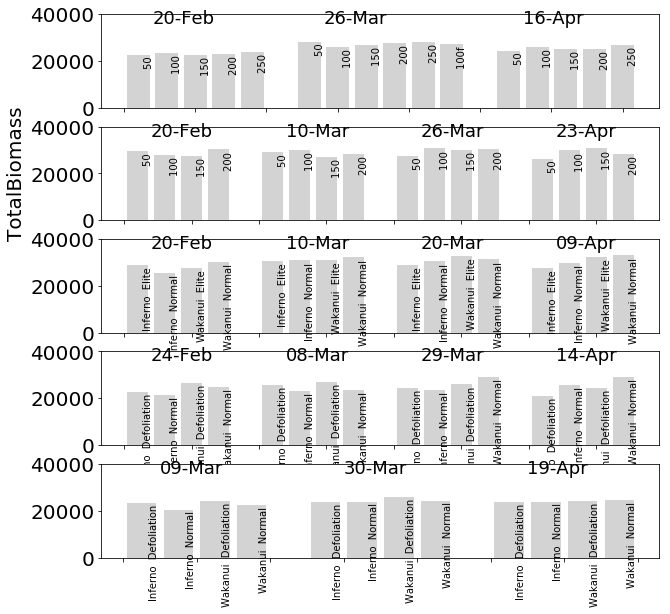

In [113]:
Variable = 'TotalBiomass'
MakeHarvestVariableGraph(Variable)

## Harvest correlations

In [114]:
['GrainsMSq','EarsMSq','StemsMSq','GrainsEar','1000GrainWt0Pc','GrainsPerGramStem',
 'TotalBiomass','HI','StemBiomass','StemBiomass','AnthesisBiomass','AnthesisStem']

['GrainsMSq',
 'EarsMSq',
 'StemsMSq',
 'GrainsEar',
 '1000GrainWt0Pc',
 'GrainsPerGramStem',
 'TotalBiomass',
 'HI',
 'StemBiomass',
 'StemBiomass',
 'AnthesisBiomass',
 'AnthesisStem']

C:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


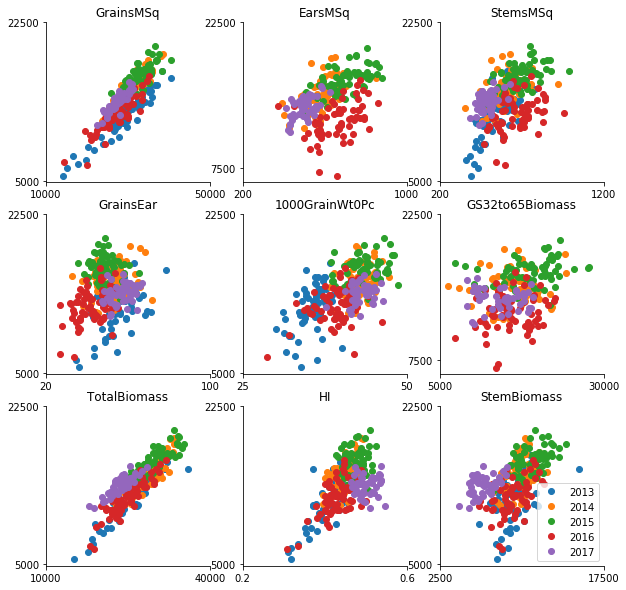

In [115]:
YVariable = 'Grain14Percent'
ComponentPairs = [['GrainsMSq',YVariable],
                  ['EarsMSq',YVariable],
                  ['StemsMSq',YVariable],
                  ['GrainsEar',YVariable],
                  ['1000GrainWt0Pc',YVariable],
                  ['GS32to65Biomass',YVariable],
                  ['TotalBiomass',YVariable],
                  ['HI',YVariable],
                  ['StemBiomass',YVariable]]
Graph = plt.figure(figsize=(10,10))
pos = 1
for Component in ComponentPairs:
    Ax = Graph.add_subplot(3,3,pos)
    Ax.spines['right'].set_visible(False)
    Ax.spines['top'].set_visible(False)
    plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on')
    plt.tick_params(axis='y', which='both', left='on',right='off', labelbottom='on')
    for Year in YearList:
        XData = IndexedData.loc[Year,Component[0]]
        YData = IndexedData.loc[Year,Component[1]]
        plt.plot(XData,YData,'o',label=Year)
        #plt.ylabel(Component[1])
        plt.title(Component[0])
    Ax.set_xticks([Ax.get_xticks()[0],Ax.get_xticks()[-1]])
    Ax.set_yticks([Ax.get_yticks()[1],Ax.get_yticks()[-1]])
    #Ax.set_xticklabels(['Less','More'])
    #Ax.set_yticklabels(['Modest','Jolly Good'])
    if pos == 9:
        plt.legend(loc=0,numpoints=1)
    pos+=1

## Met data variables

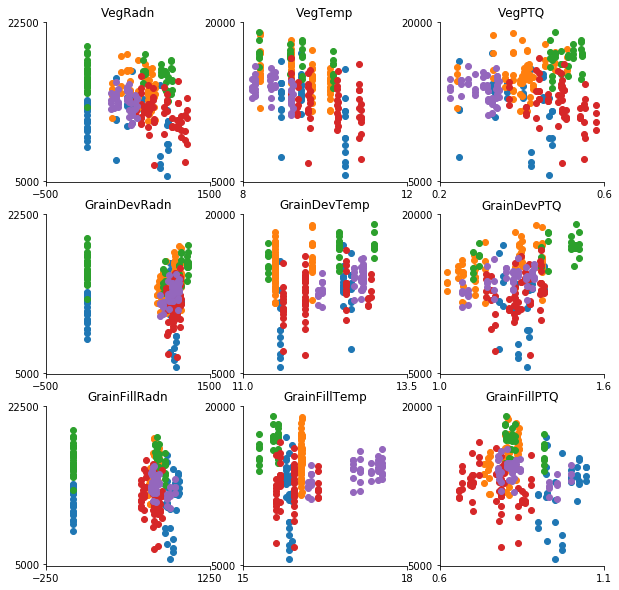

In [117]:
YVariable = 'Grain14Percent'
ComponentPairs = [['VegRadn',YVariable],
                  ['VegTemp',YVariable],
                  ['VegPTQ',YVariable],
                  ['GrainDevRadn',YVariable],
                  ['GrainDevTemp',YVariable],
                  ['GrainDevPTQ',YVariable],
                  ['GrainFillRadn',YVariable],
                  ['GrainFillTemp',YVariable],
                  ['GrainFillPTQ',YVariable]]
Graph = plt.figure(figsize=(10,10))
pos = 1
for Component in ComponentPairs:
    Ax = Graph.add_subplot(3,3,pos)
    Ax.spines['right'].set_visible(False)
    Ax.spines['top'].set_visible(False)
    plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True)
    plt.tick_params(axis='y', which='both', left=True,right=False, labelbottom=True)
    for Year in YearList:
        XData = IndexedData.loc[Year,Component[0]]#.groupby(level='SowingDate').mean()
        YData = pd.to_numeric(IndexedData.loc[Year,Component[1]])#.groupby(level='SowingDate').mean()
        plt.plot(XData,YData,'o',label=Year)
        #plt.ylabel(Component[1])
        plt.title(Component[0])
    Ax.set_xticks([Ax.get_xticks()[0],Ax.get_xticks()[-1]])
    Ax.set_yticks([Ax.get_yticks()[1],Ax.get_yticks()[-1]])
#     if pos == 9:
#         plt.legend(loc=0,numpoints=1)
    pos+=1

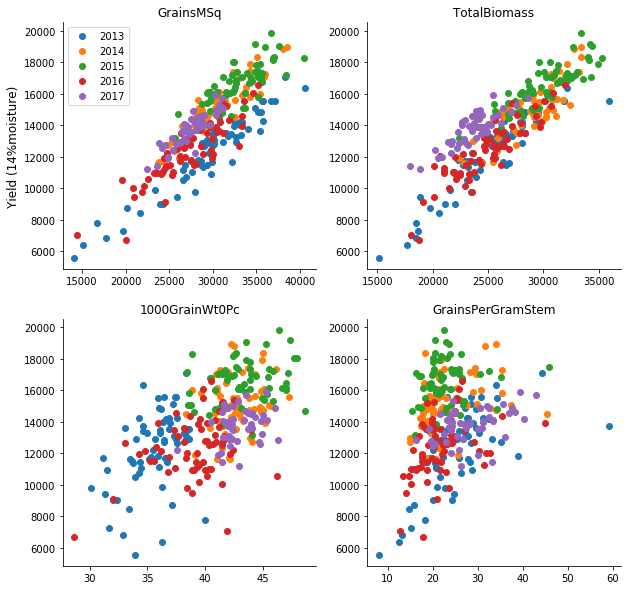

In [118]:
ComponentPairs = [['GrainsMSq','Grain14Percent'],
                  ['TotalBiomass','Grain14Percent'],
                  ['1000GrainWt0Pc','Grain14Percent'],
                 ['GrainsPerGramStem','Grain14Percent']]
Graph = plt.figure(figsize=(10,10))
pos = 1
for Component in ComponentPairs:
    Ax = Graph.add_subplot(2,2,pos)
    Ax.spines['right'].set_visible(False)
    Ax.spines['top'].set_visible(False)
    plt.tick_params(axis='x', which='both', bottom= True,top= False, labelbottom= True)
    plt.tick_params(axis='y', which='both', left= True,right= False, labelbottom= True)
    for Year in YearList:
        XData = IndexedData.loc[Year,Component[0]]
        YData = IndexedData.loc[Year,Component[1]]
        plt.plot(XData,YData,'o',label=Year)
        #plt.ylabel(Component[1])
        plt.title(Component[0])
    #Ax.set_xticks([Ax.get_xticks()[0],Ax.get_xticks()[-1]])
    #Ax.set_yticks([Ax.get_yticks()[1],Ax.get_yticks()[-1]])
    #Ax.set_xticklabels(['Less','More'])
    #Ax.set_yticklabels(['Modest','Jolly Good'])
    if pos == 1:
        plt.legend(loc=0,numpoints=1)
        plt.ylabel('Yield (14%moisture)',fontsize = 12)
    pos+=1

[]

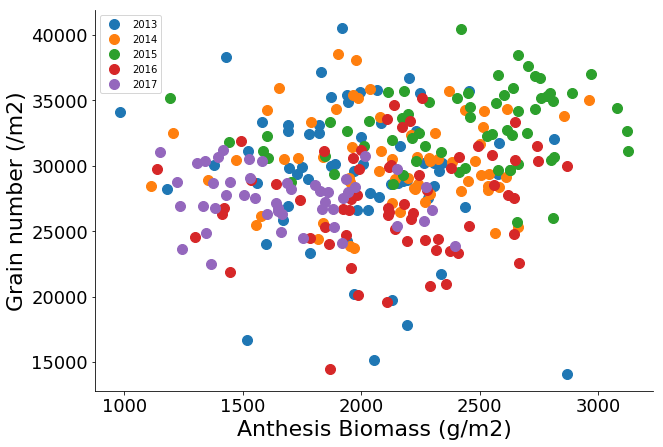

In [119]:
Graph = plt.figure(figsize=(10,7))
Ax = Graph.add_subplot(1,1,1)
Ax.spines['right'].set_visible(False)
Ax.spines['top'].set_visible(False)
plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True)
plt.tick_params(axis='y', which='both', left=True,right=False, labelbottom=True)
for Year in YearList:
    XData = IndexedData.loc[Year,'AnthesisBiomass']/10
    YData = IndexedData.loc[Year,'GrainsMSq']
    plt.plot(XData,YData,'o',label=Year,markersize = 10)
    #plt.ylabel(Component[1])
    #plt.title(Component[0])
plt.legend(loc=0,numpoints=1)
plt.ylabel('Grain number (/m2)',fontsize = 22)
plt.xlabel('Anthesis Biomass (g/m2)',fontsize = 22)
#plt.xlabel(r'$Grains /m^2$',fontsize = 22)
plt.tick_params(labelsize=18)
#Ax.xaxis.set_ticklabels([15,20,25,30,35,40])
#Ax.yaxis.set_ticklabels([4,6,8,10,12,14,16,18,20])
plt.plot()

## Single variable Harvest correlations

In [120]:
'GrainsMSq','Grain14Percent','EarsMSq','StemsMSq','GrainsEar',
'ThousandGrainWeight','GrainsPerGramStem','TotalBiomass','HI','StemBiomass'

('ThousandGrainWeight',
 'GrainsPerGramStem',
 'TotalBiomass',
 'HI',
 'StemBiomass')

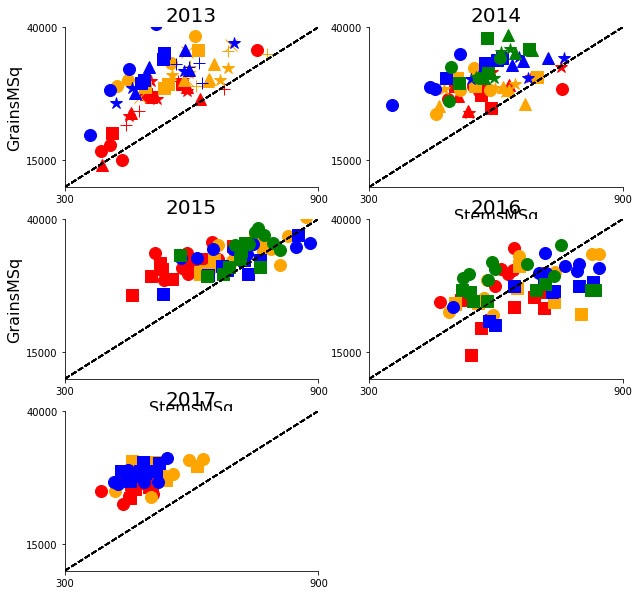

In [123]:
XVar = 'StemsMSq'
YVar = 'GrainsMSq'
MakeSingleVariableRegression(XVar,YVar)

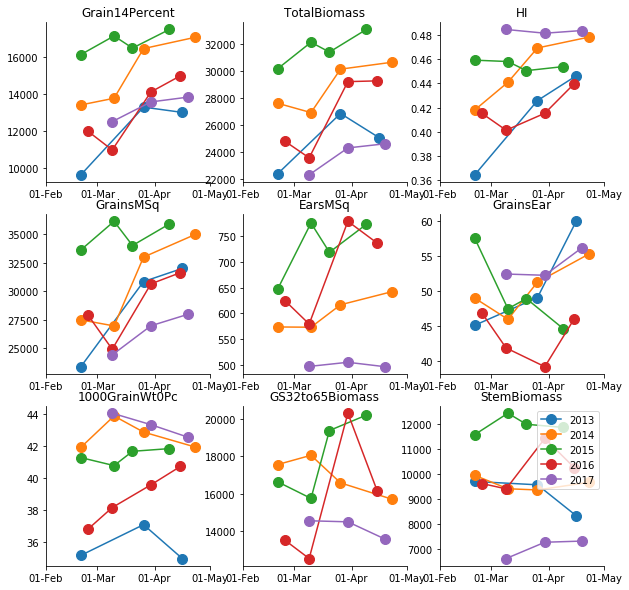

In [127]:
import matplotlib.dates as mdates
Variables = ['Grain14Percent','TotalBiomass','HI',
             'GrainsMSq','EarsMSq','GrainsEar',
             '1000GrainWt0Pc','GS32to65Biomass','StemBiomass']
Filter = (IndexedData.PlantPopn==150)&(IndexedData.Cultivar == 'Wakanui')&(IndexedData.PGRCanopyMgmtTrt=='Normal')&(IndexedData.SampleGS=='GS90')
Graph = plt.figure(figsize=(10,10))
pos = 1
for var in Variables:
    Ax = Graph.add_subplot(3,3,pos)
    Ax.spines['right'].set_visible(False)
    Ax.spines['top'].set_visible(False)
    plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True)
    plt.tick_params(axis='y', which='both', left=True,right=False, labelbottom=True)
    for Year in YearList:
        SowDateMeans = pd.DataFrame(pd.to_numeric(IndexedData.loc[Filter,var][Year]).groupby(level='SowingDate').mean())
        SowDateMeans.loc[:,'SowJDay'] = [dt.datetime(2010,1,1) + (x - dt.datetime(x.year,1,1)) for x in SowDateMeans.index]
        plt.plot(SowDateMeans.SowJDay,SowDateMeans.loc[:,var],'-o',markersize=10,label=Year)
    myFmt = mdates.DateFormatter('%d-%b')
    Ax.xaxis.set_major_formatter(myFmt)
    plt.xlim('2010-02-01','2010-05-01')
    Ax.xaxis.set_ticks(['2010-02-01','2010-03-01','2010-04-01','2010-05-01'])
    plt.title(var)
    if pos == 9:
        plt.legend(loc=1,numpoints=1)
    pos+=1

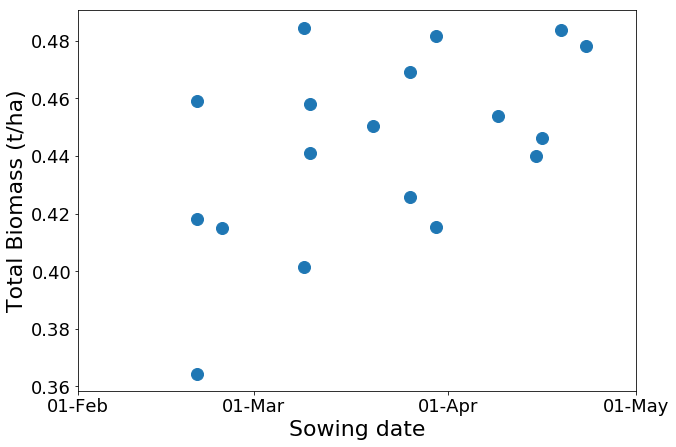

In [129]:
Graph = plt.figure(figsize=(10,7))
import matplotlib.dates as mdates

Filter = (IndexedData.PlantPopn==150)&(IndexedData.Cultivar == 'Wakanui')&(IndexedData.PGRCanopyMgmtTrt=='Normal')&(IndexedData.SampleGS=='GS90')
SowDateMeans = pd.DataFrame(pd.to_numeric(IndexedData.loc[Filter,'HI']).groupby(level='SowingDate').mean())
SowDateMeans.loc[:,'SowJDay'] = [dt.datetime(2010,1,1) + (x - dt.datetime(x.year,1,1)) for x in SowDateMeans.index]
#SowDateMeans.index.strftime('%d-%b')
ax = Graph.add_subplot(1,1,1)
plt.plot(SowDateMeans.SowJDay,SowDateMeans.HI,'o',markersize=12)
myFmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_formatter(myFmt)
plt.xlim('2010-02-01','2010-05-01')
ax.xaxis.set_ticks(['2010-02-01','2010-03-01','2010-04-01','2010-05-01'])
plt.ylabel('Total Biomass (t/ha)',fontsize=22)
plt.xlabel('Sowing date',fontsize=22)
plt.tick_params(labelsize=18)
#ax.yaxis.set_ticklabels([22,24,26,28,30,32,34])

## Extract a subset of mean data and export

In [131]:
pd.set_option("display.max_columns",101)

In [132]:
FloweringFilter = IndexedData.loc[:,'ApproxGS']=='Flowering'

In [133]:
#List variables to export
Vars = ['Location',
        'SampleDate',
        'TrialCode',
        'TrtNum',
        'NumLigules',
        'I/Io',
        'ReassessmentGS',
        'TotalBiomass',
        'Grain0Percent',
        'StemBiomass',
        'EarBiomass',
        'ChaffBiomass',
        'TotalLeafBiomass',
        'GreenLeafBiomass',
        'DeadLeafBiomass',
        'GrainsMSq',
        'StemsMSq',
        '1000GrainWt0Pc']

#Extrat these into a data frame and set sample date into the index
BaseData = IndexedData.loc[:,Vars].set_index(['SampleDate','TrialCode','TrtNum','Location'],append=True)

#Get rid of non-numeric values
for Col in BaseData.columns:
    BaseData.loc[:,Col] = pd.to_numeric(BaseData.loc[:,Col])

#Group data to give means
ExportData = BaseData.groupby(level=['Location',
                                     'TrtNum',
                                     'YearSown',
                                       'SowingDate',
                                       'Cultivar',
                                       'PlantPopn',
                                       'PGRCanopyMgmtTrt',
                                       'SampleDate']).mean().dropna(how='all')


In [134]:
def setTreatment(x):
    Year = ExportData.index.get_level_values(2)[x]
        if Year in [2013,2014]:
        treat = 'Popn' + str(ExportData.index.get_level_values(5)[x])
    else:
        treat = 'Cm' + str(ExportData.index.get_level_values(6)[x])
    return treat
    

In [152]:
ExportData.loc[:,'Experiment'] = [ExportData.index.get_level_values(0)[x]+str(ExportData.index.get_level_values(2)[x]) for x in range(ExportData.index.size)]
ExportData.loc[:,'ExpSD'] = [ExportData.iloc[x,:].loc['Experiment'] +'Sow'+ ExportData.index.get_level_values(3)[x].strftime('%d-%b') for x in range(ExportData.index.size)]
ExportData.loc[:,'SimulationName'] = [ExportData.iloc[x,:].loc['ExpSD'] + setTreatment(x) for x in range(ExportData.index.size)]
ExportData.set_index('SimulationName',drop=False,append=True,inplace=True)
ExportData.index = ExportData.index.droplevel(level=[0,1,2,3,4,5,6])
ExportData.index = ExportData.index.swaplevel('SimulationName','SampleDate')
ExportData = ExportData.loc[:,ExportData.columns.drop(['Experiment','ExpSD','SimulationName'])]
ExportData.index.names=['SimulationName','Clock.Today']

In [153]:
APSIMLabels = ['Wheat.Leaf.ExpandedCohortNo',
 'Wheat.Leaf.CoverGreen','Wheat.Phenology.Zadok.Stage','Wheat.AboveGround.Wt',
 'Wheat.Grain.Wt','Wheat.Stem.Wt','Wheat.Ear.Wt','Wheat.Spike.Wt',
 'Wheat.Leaf.Wt','Wheat.Leaf.Live.Wt','Wheat.Leaf.Dead.Wt',
 'Wheat.Grain.Number','Wheat.Structure.TotalStemPopn','Wheat.Grain.Size']

In [154]:
ExportData.columns = APSIMLabels

In [155]:
def HarvestMarker(x):
    if np.isnan(ExportData.iloc[x,:]['Wheat.Grain.Wt']):
        return ''
    else:
        return 'HarvestRipe'

In [156]:
ExportData.loc[:,'Wheat.Phenology.CurrentStageName'] = [HarvestMarker(x) for x in range(ExportData.index.size)]

C:\Anaconda\lib\site-packages\ipykernel\ipkernel.py:208: PerformanceWarning: indexing past lexsort depth may impact performance.
  res = shell.run_cell(code, store_history=store_history, silent=silent)


In [157]:
#Copy colum headers in from excel master observed file
ObsIndex = [u'Wheat.SowingData.Cultivar', u'ET', u'ProfileWater',
       u'Soil.SoilWater.SW(1)', u'Soil.SoilWater.SW(2)',
       u'Soil.SoilWater.SW(3)', u'Soil.SoilWater.SW(4)',
       u'Soil.SoilWater.SW(5)', u'Soil.SoilWater.SW(6)',
       u'Soil.SoilWater.SW(7)', u'Soil.SoilWater.SW(8)',
       u'Soil.SoilWater.SW(9)', u'Soil.SoilWater.SW(10)', u'TillerNo',
       u'Wheat.AboveGround.N', u'Wheat.AboveGround.Wt', u'Wheat.Ear.Wt',
       u'Wheat.Ear.Nconc', u'Wheat.Ear.N', u'Wheat.Grain.NConc',
       u'Wheat.Grain.Size', u'Wheat.Grain.N', u'Wheat.Grain.Number',
       u'Wheat.Grain.Protein', u'Wheat.Grain.Wt',
       u'Wheat.Structure.LeafTipsAppeared', u'Wheat.Leaf.CoverTotal',
       u'Wheat.Leaf.CoverGreen', u'Wheat.Leaf.Dead.NConc',
       u'Wheat.Leaf.Dead.N', u'Wheat.Leaf.Dead.Wt', u'Wheat.Leaf.DeadCohortNo',
       u'Wheat.Leaf.ExpandedCohortNo', u'Wheat.Leaf.LAI',
       u'Wheat.Leaf.Live.NConc', u'Wheat.Leaf.Live.N', u'Wheat.Leaf.Live.Wt',
       u'Wheat.Leaf.NonStructural.Wt', u'Wheat.Leaf.Wt',
       u'Wheat.Leaf.SpecificArea', u'Wheat.Phenology.CurrentStageName',
       u'Wheat.Phenology.FlagLeafDAS.Value()',
       u'Wheat.Phenology.FloweringDAS.Value()',
       u'Wheat.Phenology.ReadyForHarvestDAS.Value()',
       u'Wheat.Phenology.Zadok.Stage', u'Wheat.Population', u'Wheat.Spike.N',
       u'Wheat.Spike.NonStructural.Wt', u'Wheat.Spike.Wt',
       u'Wheat.Spike.NConc', u'Wheat.Stem.NConc', u'Wheat.Stem.N',
       u'Wheat.Stem.NonStructural.Wt', u'Wheat.Stem.Wt',
       u'Wheat.Structure.TotalStemPopn', u'Wheat.Structure.HaunStage.Value()',
       u'Wheat.Leaf.CohortMaxSize(1)', u'Wheat.Leaf.CohortMaxSize(2)',
       u'Wheat.Leaf.CohortMaxSize(3)', u'Wheat.Leaf.CohortMaxSize(4)',
       u'Wheat.Leaf.CohortMaxSize(5)', u'Wheat.Leaf.CohortMaxSize(6)',
       u'Wheat.Leaf.CohortMaxSize(7)', u'Wheat.Leaf.CohortMaxSize(8)',
       u'Wheat.Leaf.CohortMaxSize(9)', u'Wheat.Leaf.CohortMaxSize(10)',
       u'Wheat.Leaf.CohortMaxSize(11)', u'Wheat.Leaf.CohortMaxSize(12)',
       u'Wheat.Leaf.CohortMaxSize(13)', u'Wheat.Leaf.CohortMaxSize(14)',
       u'Wheat.Leaf.CohortMaxSize(15)', u'Wheat.Leaf.CohortMaxSize(16)',
       u'Wheat.Leaf.CohortMaxSize(17)', u'Wheat.Leaf.CohortMaxSize(18)',
       u'TopSoilWater']

In [158]:
ExportData = ExportData.loc[:,ObsIndex]

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


In [159]:
# Remember to change the destination file!!!
ExportData.to_excel('K:\CPDiary\Data\FAR 20by2020\BiomassData.xlsx',sheet_name='BiomassData',merge_cells=False)